## About

This project was inspired by the [CAMELYON16 Grand Challenge](https://camelyon17.grand-challenge.org), which focuses on medical imaging and dedicates to explore more accurate and efficient deep learning algorithms to detect cancarous cells from gigapixel biopsy images. Data used in this project consists of slides and tumor masks from the [CAMELYON16](https://camelyon17.grand-challenge.org/Data/) dataset. This notebook was built in Colab utilizing the GPUs of Colab, and [OpenSlide](https://openslide.org/) was installed in Colab to process whole slide images. 


In [3]:
# Install the OpenSlide C library and Python bindings
!apt-get install openslide-tools
!pip install openslide-python

Reading package lists... Done
Building dependency tree       
Reading state information... Done
openslide-tools is already the newest version (3.4.1+dfsg-2).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 34 not upgraded.


In [4]:
#!pip install tensorflow.io
!pip install imblearn

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import numpy as np
from openslide import open_slide, __library_version__ as openslide_version
import os
from PIL import Image
from skimage.color import rgb2gray
import glob
import random
import time
import pathlib
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras import models, layers, optimizers
from tensorflow.keras.utils import plot_model

from imblearn.over_sampling import RandomOverSampler
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import RandomUnderSampler
from imblearn.under_sampling import NearMiss

# Set a random seed for reproduction.
RANDOM_STATE = np.random.seed(2021)

AUTOTUNE = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 64
IMG_SIZE = 128
CENTRAL_GRID = 90
SHUFFLE_SIZE = 100
METRICS = [
      #tf.keras.metrics.TruePositives(name='tp'),
      #tf.keras.metrics.FalsePositives(name='fp'),
      #tf.keras.metrics.TrueNegatives(name='tn'),
      #tf.keras.metrics.FalseNegatives(name='fn'), 
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc'),
      tf.keras.metrics.PrecisionAtRecall(recall=0.5, name='precisionAtRecall')
]



## Exploring A Sample Slide 

In [6]:
# Download an example slide and tumor mask
sample_slide_path = 'tumor_091.tif' # only this file is available
sample_mask_path = 'tumor_091_mask.tif' # only this file is available

sample_slide_url = 'https://storage.googleapis.com/applied-dl/%s' % sample_slide_path
sample_mask_url = 'https://storage.googleapis.com/applied-dl/%s' % sample_mask_path

# Download the whole slide image
if not os.path.exists(sample_slide_path):
  !curl -O $sample_slide_url

# Download the tumor mask
if not os.path.exists(sample_mask_path):
  !curl -O $sample_mask_url

In [7]:
def read_tif (slide_path, mask_path, print_dimension = False):
    """
    Reads slide and mask slide from path and returns two OpenSlide objects
    """

    slide = open_slide(slide_path)
    print ("Read tif from %s with width: %d, height: %d" % (slide_path, 
                                                        slide.level_dimensions[0][0], 
                                                        slide.level_dimensions[0][1]))

    tumor_mask = open_slide(mask_path)
    #print ("Read tumor mask from %s" % (tumor_mask_path))

    print("Slide includes {} levels".format(len(slide.level_dimensions)))
    print('-'*50)
    if print_dimension:
        for i in range(len(slide.level_dimensions)):
            print("Level %d, dimensions: %s downsample factor %d" % (i, 
                                                             slide.level_dimensions[i], 
                                                             slide.level_downsamples[i]))
            assert tumor_mask.level_dimensions[i][0] == slide.level_dimensions[i][0]
            assert tumor_mask.level_dimensions[i][1] == slide.level_dimensions[i][1]

        # Verify downsampling works as expected
        width, height = slide.level_dimensions[7]
        assert width * slide.level_downsamples[7] == slide.level_dimensions[0][0]
        assert height * slide.level_downsamples[7] == slide.level_dimensions[0][1]
    return slide, tumor_mask

In [8]:
read_tif(sample_slide_path, sample_mask_path, print_dimension = True)

Read tif from tumor_091.tif with width: 61440, height: 53760
Slide includes 8 levels
--------------------------------------------------
Level 0, dimensions: (61440, 53760) downsample factor 1
Level 1, dimensions: (30720, 26880) downsample factor 2
Level 2, dimensions: (15360, 13440) downsample factor 4
Level 3, dimensions: (7680, 6720) downsample factor 8
Level 4, dimensions: (3840, 3360) downsample factor 16
Level 5, dimensions: (1920, 1680) downsample factor 32
Level 6, dimensions: (960, 840) downsample factor 64
Level 7, dimensions: (480, 420) downsample factor 128


(OpenSlide('tumor_091.tif'), OpenSlide('tumor_091_mask.tif'))

In [9]:
# See https://openslide.org/api/python/#openslide.OpenSlide.read_region
# Note: x,y coords are with respect to level 0.

# Read a region from the slide
# Return a numpy RBG array
def read_slide(slide, x, y, level, width, height, as_float=False):
    im = slide.read_region((x,y), level, (width, height))
    im = im.convert('RGB') # drop the alpha channel
    if as_float:
        im = np.asarray(im, dtype=np.float32)
    else:
        im = np.asarray(im)
    assert im.shape == (height, width, 3)
    return im

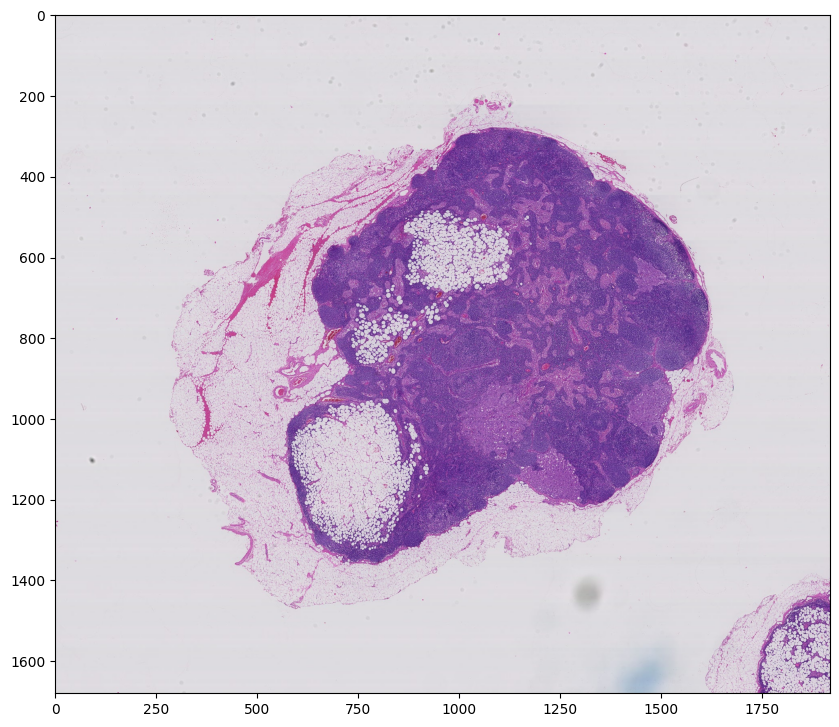

In [10]:
# Use the sliding window approach to collect training data
sample_slide = open_slide(sample_slide_path)
sample_slide_image = read_slide(sample_slide, 
                         x=0, 
                         y=0, 
                         level=5, 
                         width=sample_slide.level_dimensions[5][0], 
                         height=sample_slide.level_dimensions[5][1])

plt.figure(figsize=(10,10), dpi=100)
plt.imshow(sample_slide_image)

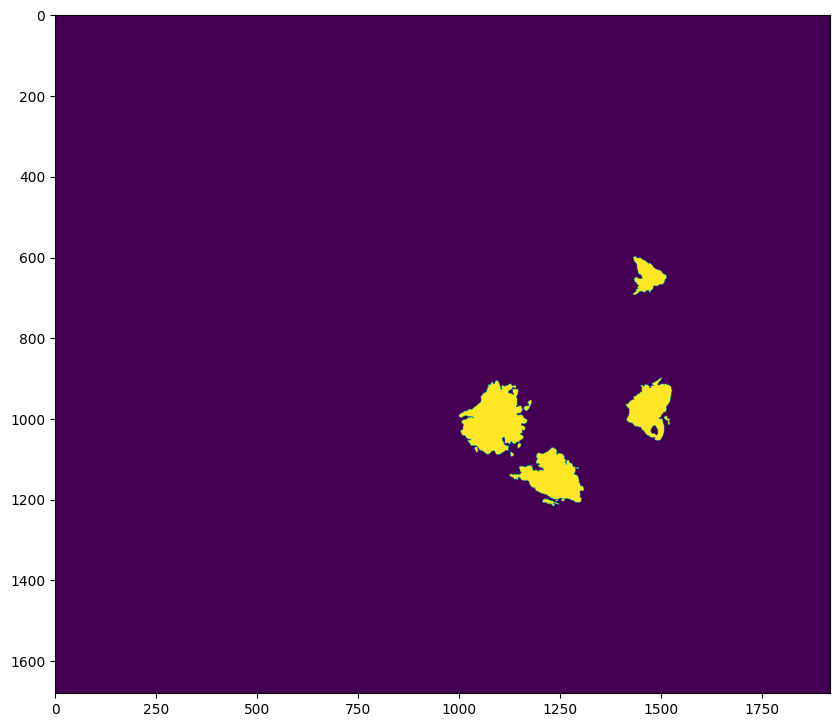

In [11]:
# Example: read the entire mask at the same zoom level
sample_mask = open_slide(sample_mask_path)
sample_mask_image = read_slide(sample_mask, 
                        x=0, 
                        y=0, 
                        level=5, 
                        width=sample_slide.level_dimensions[5][0], 
                        height=sample_slide.level_dimensions[5][1])

# Note: the program provided by the dataset authors generates a mask with R,G,B channels.
# The mask info we need is in the first channel only.
# If you skip this step, the mask will be displayed as all black.
sample_mask_image = sample_mask_image[:,:,0]

plt.figure(figsize=(10,10), dpi=100)
plt.imshow(sample_mask_image)

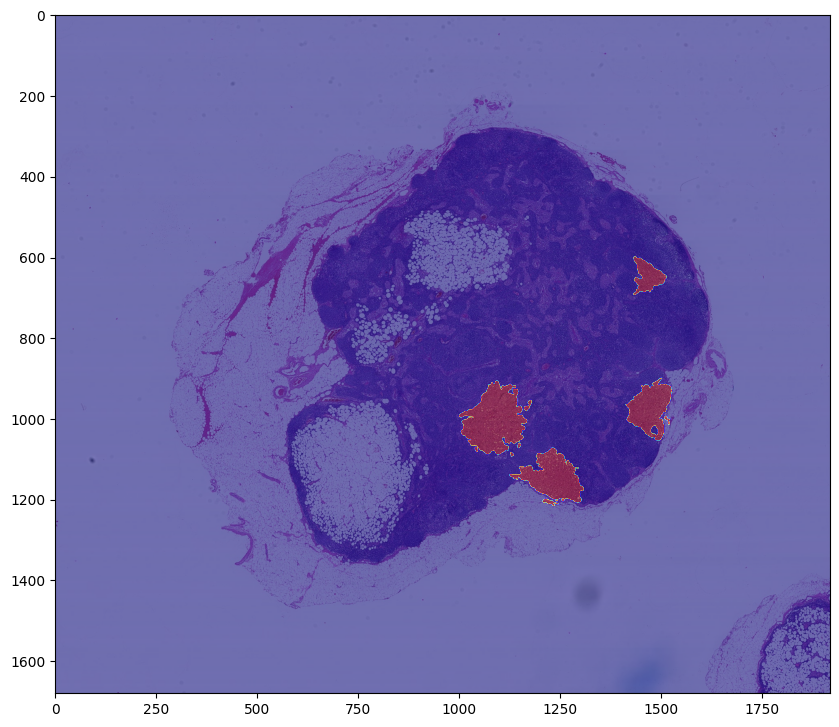

In [12]:
# Overlay them. The idea is that the mask shows the region of the slide that
# contain cancerous cells.
plt.figure(figsize=(10,10), dpi=100)
plt.imshow(sample_slide_image)
plt.imshow(sample_mask_image, cmap='jet', alpha=0.5) # Red regions contains cancer.

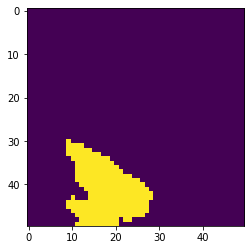

In [13]:
# Example: extract a region from the L7 downsampled image
# Notice we're multiplying the x,y coordinates by the downsample factor.
# This math can be tricky to get right, debug carefully.
# Here, we're "aiming" for the top right blob in the image above.
sample_region = read_slide(sample_mask, x=350 * 128, y=120 * 128, level=7, width=50, height=50)[:,:,0]
plt.imshow(sample_region)

905504 tissue_pixels pixels (32.1 percent of the image)


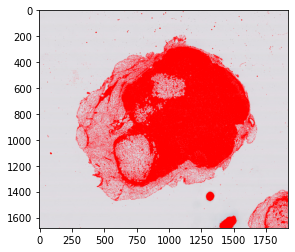

In [14]:
# Improve efficiency by ignoring non-tissue areas of the slide. 
# I found these by looking for all gray regions.
def find_tissue_pixels(image, intensity=0.8):
    im_gray = rgb2gray(image)
    assert im_gray.shape == (image.shape[0], image.shape[1])
    indices = np.where(im_gray <= intensity)
    return list(zip(indices[0], indices[1]))

tissue_pixels = find_tissue_pixels(sample_slide_image)
percent_tissue = len(tissue_pixels) / float(sample_slide_image.shape[0] * sample_slide_image.shape[0]) * 100
print ("%d tissue_pixels pixels (%.1f percent of the image)" % (len(tissue_pixels), percent_tissue)) 

def apply_mask(im, mask, color=(255,0,0)):
    masked = np.copy(im)
    for x,y in mask: masked[x][y] = color
    return masked

tissue_regions = apply_mask(sample_slide_image, tissue_pixels)
plt.imshow(tissue_regions)

## Loading Data

In [15]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)


Mounted at /content/drive


In [16]:
# tumor_038 does not have mask
def get_slide_mask(idx:str):
    """
    Reads an index as str() and returns the slide and mask loaded from the directory
    """
    s = '/content/drive/MyDrive/slides/tumor_'+ idx +'.tif'
    m = '/content/drive/MyDrive/slides/tumor_'+ idx +'_mask.tif'
    slide, mask = read_tif(s, m, print_dimension = False)
    return slide, mask

In [17]:
def full_masked_sample(idx:str, level = 5):
    """
    Reads an index as str() and plots a masked sample image with the specified level
    """
    slide, mask = get_slide_mask(idx)
    full_slide_image = read_slide(slide, 
                         x=0, 
                         y=0, 
                         level=level, 
                         width=slide.level_dimensions[level][0], 
                         height=slide.level_dimensions[level][1])
    full_mask_image = read_slide(mask, 
                         x=0, 
                         y=0, 
                         level=level, 
                         width=mask.level_dimensions[level][0], 
                         height=mask.level_dimensions[level][1])
    full_mask_image = full_mask_image[:,:,0]

    tissue_pixels = find_tissue_pixels(full_slide_image)
    percent_tissue = len(tissue_pixels) / float(full_slide_image.shape[0] * full_slide_image.shape[0]) * 100
    print ("%d tissue_pixels pixels (%.1f percent of the image)" % (len(tissue_pixels), percent_tissue)) 

    tissue_regions = apply_mask(full_slide_image, tissue_pixels)

    plt.figure(figsize=(10,10), dpi=100)
    plt.imshow(full_slide_image)
    plt.imshow(tissue_regions)
    plt.imshow(full_mask_image, cmap='jet', alpha=0.5) # Red regions contains cancer.


Read tif from /content/drive/MyDrive/slides/tumor_031.tif with width: 97792, height: 221184
Slide includes 10 levels
--------------------------------------------------
184955 tissue_pixels pixels (1.5 percent of the image)


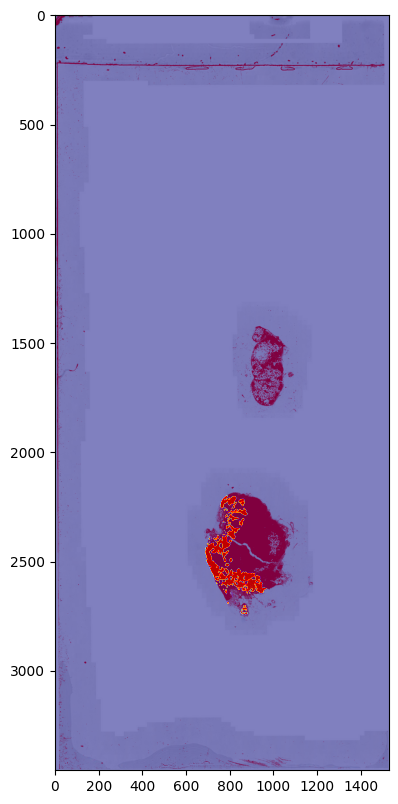

In [18]:
# plot a sample 
#full_masked_sample('110', level = 6)
full_masked_sample('031', level = 6)


## Generating Datasets

### Define functions

##### Calculate patches and binary labels

In [19]:
def patch(idx:str, level=5, patch_size=IMG_SIZE, tissue_thres = 20):
    """
    inputs
    ------
    idx: str, refers to the image name saved in the directory, e.g. '091'
    level: int, the zoom level, default is 5
    patch_size: int, the width and length of each patch, default is IMG_SIZE
    tissue_thres: int, represents the percentage in integer for defining tissue existence
                  E.g. tissue_thres=20 means only patches with >20% of pixels containing 
                  tissues are included in features

    outputs
    ------
    Feature patches (X), mask patches (y_mask), and label patches (y_label) in np.array
    """
    slide, mask = get_slide_mask(idx)
    X = []
    y_mask =[]
    y_label = []
    patch_position = []

    n_patches = 0
    total_patches = 0
    for i in np.arange(0, slide.level_dimensions[level][0],patch_size):
        for j in np.arange(0, slide.level_dimensions[level][1],patch_size):
            slide_patch = read_slide(slide, x=i * (2**level), y=j * (2**level), 
                           level=level, width=patch_size, height=patch_size)
            mask_patch = read_slide(mask, x=i * (2**level), y=j * (2**level), 
                            level=level, width=patch_size, height=patch_size)[:,:,0]
            #print(mask_patch.shape)
            total_patches += 1
            tissue_pixels = find_tissue_pixels(slide_patch)
            percent_tissue = len(tissue_pixels) / float(slide_patch.shape[0] **2) * 100
            #print(percent_tissue)
            if percent_tissue > tissue_thres:
                # record position of patch
                patch_position.append([i,j])
                # assign labels
                label = 1 if np.array(np.where(mask_patch>0)).shape[1] > patch_size*2 else 0
                #print(np.array(np.where(mask_patch>0)).shape)
                X.append(slide_patch)
                y_mask.append(mask_patch)
                y_label.append(label)
                n_patches += 1
            else:
                pass
    positive = np.array(np.where(np.array(y_label) == 1)).flatten()
    percent_effective = round(n_patches / total_patches *100, 1)
    print("Got {} effective patches ({}% of total {} patches) from level {}".format(n_patches, 
                                                                      percent_effective, total_patches,level))
    print("{} positive labels ({}% of total).".format(positive.shape[0], 
                                                     round(positive.shape[0]/ total_patches *100, 1)))
    print('-'*50)
    return np.array(X), np.array(y_mask), np.array(y_label)

##### Train/test split

In [20]:
def split_train_test(X, y, train_size = 0.6, test_size=0.2):

    """
    inputs
    ------
    X: np.array, patches extracted from slide
    y: np.array, can be y_mask or y_label
    train_size: float, between 0 and 1
    test_size: float, between 0 and 1, and train_size + test_size <=1

    outputs
    ------
    Splitted train, validation, and test datasets in np.array
    """

    assert train_size + test_size <= 1, "Sum of train and test sizes <= 1"
    #assert train_size - test_size >= 0, "Train data should be larger than test data"

    # First, split to get train data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1-train_size, random_state=RANDOM_STATE)
    # Then, split test vs. validation data
    X_val, X_test, y_val, y_test = train_test_split(X_test,y_test, test_size=test_size, random_state=RANDOM_STATE)

    return X_train, X_val, X_test, y_train, y_val, y_test

##### Resample

In [21]:
def resample(X, y, method = 'ovs', ratio = 'auto'):
    """
    inputs
    ---------
    X: np.array, patches extracted from slide(s)
    y: np.array, labels for patches
    method: str, resampling method with posible values {'ovs', 'smk','custom'}, default is 'ovs'
    ratio: str or int, the resampling ratio, an int represents the ratio of majority class over the minority

    outputs
    ---------
    resampled X and y in np.array
    """

    X = X.reshape(y.shape[0], -1)

    if ratio != 'auto':
        ratio = {1: round(y.shape[0]/ratio), 0: y.shape[0]}

    if method == 'ovs':
        ovs = RandomOverSampler(random_state = RANDOM_STATE,ratio = ratio)
        res_X, res_y = ovs.fit_resample(X,y)
        print("Random oversampling")

    elif method == 'smk':
        smk = SMOTETomek(random_state = RANDOM_STATE,ratio = ratio)
        res_X, res_y = smk.fit_resample(X,y)
        print("Oversampling and undersampling")

    res_X[np.where(res_X>255)]=255
    res_X[np.where(res_X<0)]=0

    print("Positive:", res_X[np.where(res_y==1),:].reshape(-1,128,128,3).shape[0],
          "\nNegative:", res_X[np.where(res_y==0),:].reshape(-1,128,128,3).shape[0])
    print("-"*50)
    res_X = res_X.reshape(-1,128,128,3)
    return res_X, res_y

##### Generate tensorflow datasets

In [22]:
def generate_ds(X_train, y_train, X_val, y_val, X_test, y_test, prefetch=True):  
    """
    Generates tensorflow datasets
    """

    train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
    val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val))
    test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test))

    train_ds = train_ds.shuffle(SHUFFLE_SIZE).batch(BATCH_SIZE)
    val_ds = val_ds.shuffle(SHUFFLE_SIZE).batch(BATCH_SIZE)
    test_ds = test_ds.batch(BATCH_SIZE)
    
    for image_batch, labels_batch in train_ds:
        print("Images batch shape:",image_batch.shape)
        print("Labels batch shape:",labels_batch.shape)
        break

    print('Number of train batches: %d' % tf.data.experimental.cardinality(train_ds))
    print('Number of validation batches: %d' % tf.data.experimental.cardinality(val_ds))
    print('Number of test batches: %d' % tf.data.experimental.cardinality(test_ds))
    print("-"*50)
    if prefetch:
        train_prefetched = train_ds.prefetch(buffer_size=AUTOTUNE)
        val_prefetched = val_ds.prefetch(buffer_size=AUTOTUNE)
        #test_prefetched = test_ds.prefetch(buffer_size=AUTOTUNE)
        return train_prefetched, val_prefetched, test_ds
    else:
        return train_ds, val_ds, test_ds

### Prepare data

**NOTE:**

**Change variables/controls BELOW to generate datasets and train models at different levels**

Read tif from /content/drive/MyDrive/slides/tumor_031.tif with width: 97792, height: 221184
Slide includes 10 levels
--------------------------------------------------
Got 977 effective patches (4.7% of total 20736 patches) from level 3
234 positive labels (1.1% of total).
--------------------------------------------------
Read tif from /content/drive/MyDrive/slides/tumor_064.tif with width: 97792, height: 220672
Slide includes 10 levels
--------------------------------------------------
Got 1321 effective patches (6.4% of total 20736 patches) from level 3
171 positive labels (0.8% of total).
--------------------------------------------------
Read tif from /content/drive/MyDrive/slides/tumor_091.tif with width: 61440, height: 53760
Slide includes 8 levels
--------------------------------------------------
Got 987 effective patches (31.0% of total 3180 patches) from level 3
82 positive labels (2.6% of total).
--------------------------------------------------
Read tif from /content/driv

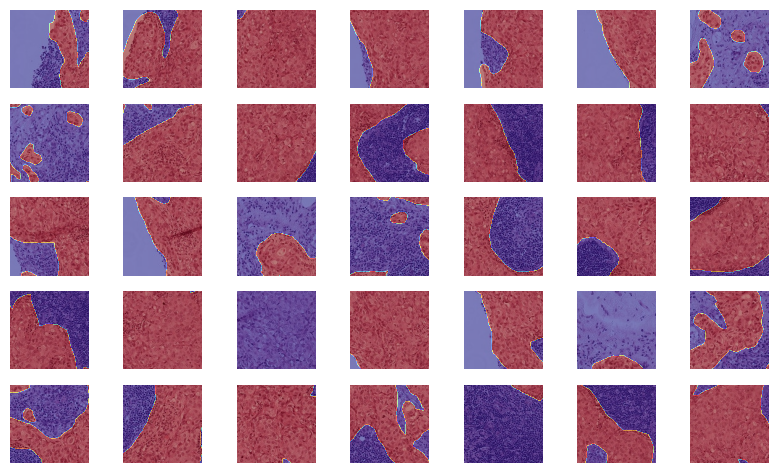

In [23]:
IDX = ['031','064','091','016','078']  #['031','064','091']
LEVEL_LIST = [3] #[3] #[4,5]
SINGLE_LEVEL = 3 #4 #5
PLOT_SAMPLE = True
SAVE_DATA = False
RESAMPLE_OVS = True
RESAMPLE_SMK = False
MULTI_IDX = True


if MULTI_IDX:
    X = np.empty(shape = (0, IMG_SIZE, IMG_SIZE, 3))
    y_mask = np.empty(shape = (0, IMG_SIZE, IMG_SIZE))
    y_label = np.empty(shape = (0))
    for i in IDX:
        for level in LEVEL_LIST:
          s,m,l = patch(idx=i, level=level, patch_size=IMG_SIZE, tissue_thres = 30)
          X = np.append(X,s,axis=0)
          y_mask = np.append(y_mask,m,axis=0)
          y_label = np.append(y_label,l,axis=0)
else:
    # Single level and single slide
    X,y_mask,y_label = patch(idx='091', level=SINGLE_LEVEL, 
                             patch_size=IMG_SIZE, tissue_thres = 30)

X = X.astype('int64')
y_mask = y_mask.astype('int64')
y_label = y_label.astype('int64')
# class counts
neg, pos = np.bincount(y_label.astype('int64'))
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))
# class_weights
weight_for_0 = (1 / neg)*(total) 
weight_for_1 = (1 / pos)*(total)
class_weight = {0: weight_for_0, 1: weight_for_1}
print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))
print("-"*50)
X_train, X_val, X_test, y_train, y_val, y_test = split_train_test(X, y_label)
train_ds, val_ds, test_ds = generate_ds(X_train, y_train, X_val, y_val, X_test, y_test, prefetch=True)

if PLOT_SAMPLE:
    plt.figure(figsize=(10,6), dpi=100)
    positive = np.array(np.where(y_label == 1)).flatten()
    for idx in range(35):
        i = positive[idx]
        ax = plt.subplot(5,7, idx + 1)
        plt.imshow(X[i,:])
        plt.imshow(y_mask[i,:], cmap='jet', alpha=0.5)
        #plt.title("label: {}".format(y_label[i]))
        plt.axis("off")

if RESAMPLE_OVS:
    ovs_X, ovs_y = resample(X_train, y_train, method = 'ovs', ratio=1)
    train_ovs, val_ovs, test_ovs = generate_ds(ovs_X, ovs_y, X_val, y_val, X_test, y_test, prefetch=True)
if RESAMPLE_SMK:
    smk_X, smk_y = resample(X_train, y_train, method = 'smk')
    train_smk, val_smk, test_smk = generate_ds(smk_X, smk_y, X_val, y_val, X_test, y_test, prefetch=True)

if SAVE_DATA:
    dataset = {
        'X' : X,
        'y_mask': y_mask,
        'y_label': y_label
    }
    def ds_name():
        s='./data_'
        if MULTI_IDX:
            for i in LEVEL_LIST:
                s += str(i)
        else:
            s += str(SINGLE_LEVEL)

    name = ds_name()
    np.save(name, dataset)

## Building Models

### Define Layers

In [22]:
# Define layers (Used in experiments, not all included in the final model)
scaling_layer = layers.experimental.preprocessing.Rescaling(1./255)
data_augmentation = tf.keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", input_shape=(IMG_SIZE,IMG_SIZE,3)),
    #layers.experimental.preprocessing.RandomFlip("vertical"),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ], name = 'data_augmentation'
)
dropout_layer = tf.keras.layers.Dropout(0.1)
dense1 = tf.keras.layers.Dense(64, activation='relu')
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
mask_layer = tf.keras.layers.Conv2DTranspose(1, 3, strides=2, padding='same') 


### Transfer learning

#### InceptionV3

In [23]:
base_model = tf.keras.applications.InceptionV3(include_top=False,
                                               weights="imagenet",
                                               input_shape=(IMG_SIZE, IMG_SIZE, 3))
preprocess_input = tf.keras.applications.inception_v3.preprocess_input

In [24]:
# Create new model on top.
def make_model1(output_bias = None, optimizer = 'RMS', printing=False): 
    """
    Generates a compiled tf.model.Model
    """
    if output_bias is not None:
        output_bias = tf.keras.initializers.Constant(output_bias)
    
    inputs = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    x = preprocess_input(inputs)
    x = data_augmentation(x)
    x = dropout_layer(x)
    x = base_model(x)
    x = global_average_layer(x)
    outputs = layers.Dense(1, activation='sigmoid',bias_initializer=output_bias)(x)

    model=tf.keras.models.Model(inputs,outputs) 
    if printing:   
        print(model.summary())


    if optimizer == 'adam':
        opt = tf.keras.optimizers.Adam(lr=5e-5)
    elif optimizer == 'RMS':
        opt = tf.keras.optimizers.RMSprop(lr=1e-4)
    elif optimizer == 'SGD':
        opt = tf.keras.optimizers.SGD(lr=5e-4, momentum=0.9)

    model.compile(optimizer= opt,
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=METRICS)
    return model


In [25]:
initial_bias = np.log([pos/neg])
# model naming: base_model + optimizer + bias

# Freeze base model
base_model.trainable = False
IV3frz_RMS_1= make_model1(optimizer = 'RMS')
IV3frz_RMS_2 = make_model1(output_bias = initial_bias)
# Unfreeze base model for fine tuning
base_model.trainable = True
IV3_RMS_1= make_model1(optimizer = 'RMS')
IV3_SGD_1 = make_model1(optimizer = 'SGD')
IV3_ADA_1 = make_model1(optimizer = 'adam')
IV3_RMS_2 = make_model1(output_bias = initial_bias)

#### VGG19

In [26]:
# Create new model on top.
base_model = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
preprocess_input = tf.keras.applications.vgg19.preprocess_input

base_model.trainable = True

In [27]:
VGG_RMS_1 = make_model1(optimizer = 'RMS')
VGG_SGD_1 = make_model1(optimizer = 'SGD')
VGG_ADA_1 = make_model1(optimizer = 'adam')
VGG_RMS_2 = make_model1(output_bias = initial_bias)
VGG_SGD_2 = make_model1(optimizer = 'SGD', output_bias = initial_bias)

### Train the models

**NOTE:**

**There are a lot of combinations of datasets and models with different parameters/hyperparameters (e.g. optimizers, output bias, class weights, batches, etc.). I have experimented numerous combinations and make dozens of trials, but here I only listed a couple of models to ease reading.

In [31]:
# Set up early stopping criteria
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_auc', 
    verbose=1,
    patience=15,
    mode='max',
    restore_best_weights=True)

In [32]:
epochs=100

In [ ]:
# Trial 0: original dataset + freezed InceptionV3 model with SGD optimizer
# history naming: history + dataset + trial
history_ds_0 = IV3frz_RMS_1.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  verbose = 1,
  callbacks = [early_stop], class_weight = class_weight)

In [ ]:
# Trial 1: original dataset + InceptionV3 model with SGD optimizer
history_ds_1 = IV3_SGD_1.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  verbose = 1,
  callbacks = [early_stop], class_weight = class_weight)

In [ ]:
# Trail 2: original dataset + InceptionV3 model with output bias
history_ds_2 = IV3_RMS_2.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  verbose = 1,
  callbacks = [early_stop],class_weight = class_weight)

In [ ]:
# Trial 3: original dataset + VGG19 model
history_ds_3 = VGG_SGD_1.fit(
  train_ovs,
  validation_data=val_ovs,
  epochs=epochs,
  verbose = 1,
  callbacks = [early_stop], class_weight = class_weight)

In [ ]:
# Trial 4: original dataset + VGG19 model with output bias and class weights
history_ds_4 = VGG_RMS_2.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  verbose = 1,
  callbacks = [early_stop],class_weight = class_weight)

In [ ]:
# Trial 5: original dataset + VGG19 model with output bias using SGD optimizer
history_ds_5 = VGG_SGD_2.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  verbose = 1,
  callbacks = [early_stop],class_weight = class_weight)

### Plot training history

In [40]:
def plot_history(history):
    epoch = len(history.history['accuracy'])
    
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(epoch)

    plt.figure(figsize=(15, 12))
    plt.subplot(2, 3, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 3, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')

    plt.subplot(2, 3, 3)
    plt.plot(epochs_range, history.history['auc'], label='Training AUC')
    plt.plot(epochs_range, history.history['val_auc'], label='Validation AUC')
    plt.xlabel('Epoch')
    plt.ylabel('AUC')
    plt.legend(loc='best')
    plt.title('Training and Validation AUC')

    plt.subplot(2, 3, 4)
    plt.plot(epochs_range, history.history['precision'], label='Training Precision')
    plt.plot(epochs_range, history.history['val_precision'], label='Validation Precision')
    plt.xlabel('Epoch')
    plt.ylabel('Precision')
    plt.legend(loc='best')
    plt.title('Training and Validation Precision')

    plt.subplot(2, 3, 5)
    plt.plot(epochs_range, history.history['recall'], label='Training Recall')
    plt.plot(epochs_range, history.history['val_recall'], label='Validation Recall')
    plt.xlabel('Epoch')
    plt.ylabel('Recall')
    plt.legend(loc='best')
    plt.title('Training and Validation Recall')

    plt.subplot(2, 3, 6)
    plt.plot(epochs_range, history.history['precisionAtRecall'], label='Training Precision at Recall')
    plt.plot(epochs_range, history.history['val_precisionAtRecall'], label='Validation Precision at Recall')
    plt.xlabel('Epoch')
    plt.ylabel('Precision at Recall > 0.5')
    plt.legend(loc='best')
    plt.title('Training and Validation Precision at Recall > 0.5')
    plt.show()


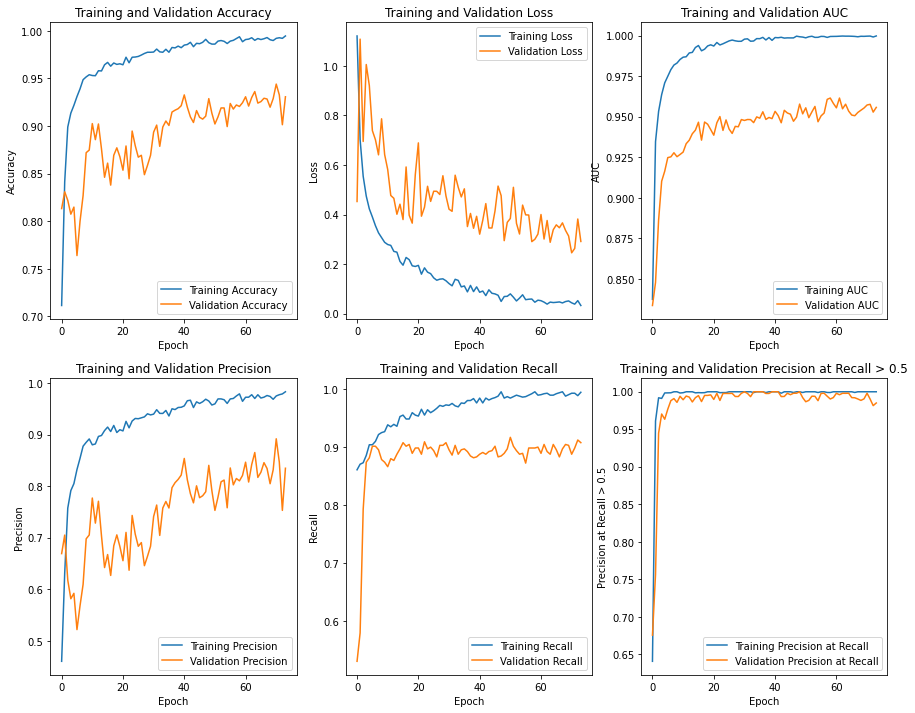

In [41]:
plot_history(history_ds_1)

## Evaluate Models

Train Slides: 016, 031, 064, 078, 091

Test Slides: 110, 101, 096



In [42]:
# Evaluation naming: eval + trial no.
eval_1 = IV3_SGD_1.evaluate(test_ds)

10/10 [==============================] - 1s 111ms/step - loss: 0.6260 - accuracy: 0.8279 - precision: 0.6485 - recall: 0.6730 - auc: 0.8146 - precisionAtRecall: 0.7885


In [43]:
eval_2 = IV3_RMS_2.evaluate(test_ds)

10/10 [==============================] - 1s 64ms/step - loss: 0.2800 - accuracy: 0.9687 - precision: 0.9728 - recall: 0.8994 - auc: 0.9459 - precisionAtRecall: 0.9929


In [44]:
eval_3 = VGG_SGD_1.evaluate(test_ds)

10/10 [==============================] - 2s 235ms/step - loss: 0.7662 - accuracy: 0.2488 - precision: 0.2488 - recall: 1.0000 - auc: 0.5000 - precisionAtRecall: 0.2488


In [45]:
eval_4 = VGG_RMS_2.evaluate(test_ds)

10/10 [==============================] - 1s 69ms/step - loss: 0.5611 - accuracy: 0.7512 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5000 - precisionAtRecall: 0.2488


## Save Model

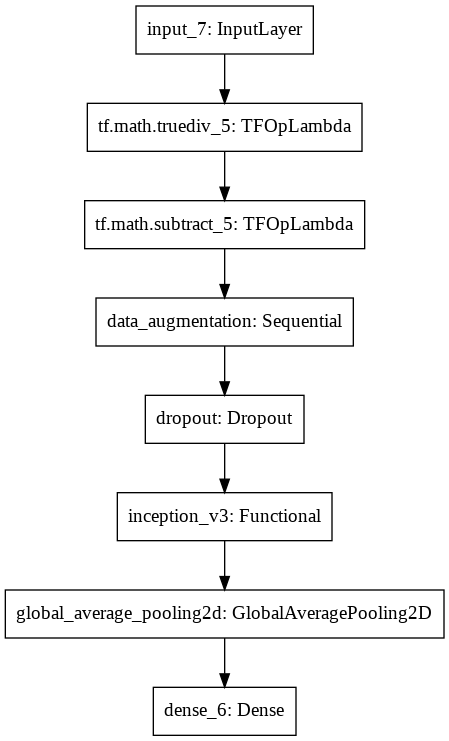

In [64]:
# plot the model structure
#plot_model(VGG_RMS_2, to_file='vgg_model.png')
plot_model(IV3_RMS_2, to_file='IV3_model.png')

In [63]:
save_path = '/content/drive/MyDrive/'
#!mkdir -p '/content/drive/MyDrive/saved_models'

#VGG_RMS_2.save(save_path+'VGG_best_model.h5')
IV3_RMS_2.save(save_path+'IV3_best_model.h5')

## Predict with The Best Model

In [ ]:
VGG_l3_model = tf.keras.models.load_model('/content/drive/MyDrive/VGG_best_model.h5')
IV3_model = tf.keras.models.load_model('/content/drive/MyDrive/IV3_best_model.h5')
VGG_l4_model = tf.keras.models.load_model('/content/drive/MyDrive/l4_model.h5')

In [27]:
def full_pred(l3_model, idx:str, l4_model=None, level = 3, cancer_thres = 0.9, patch_size=IMG_SIZE):
    """
    Predict cancer cells in an slide image
    If zoom_model is not None, this function returns multi-level predictions by fully-connected models
    for level 3 and level 4

    inputs
    ------
    l3_model: vgg model developed with level-3 patches
    idx: str, index of the slide index
    l4_model: vgg model developed with level-4 patches
    level: int, current level (reference level for plotting)
    cancer_thres: float, between 0 and 1. 
                If prediction scores > cancer_thres, we consider patches to have cancerous cells
    patch_size: the size of sliding window
    """
    # if percent_tissue > tissue_thres,
    # we consider patches to have sufficient tissues for predictions
    tissue_thres = 50
    # if using multi-level predictions, use the weight_factor to compute
    # a weighted sum of two set of logits
    weight_factor = 0.8 #weight for level-3 predictions

    X = []
    zoom_out_X = []
    y_true = []
    y_pred = []
    pred = []
    patch_position = []

    # get slide and mask
    slide, mask = get_slide_mask(idx)

    full_slide_image = read_slide(slide, 
                         x=0,y=0,level=level, 
                         width=slide.level_dimensions[level][0], 
                         height=slide.level_dimensions[level][1])
    full_mask_image = read_slide(mask, 
                         x=0,y=0,level=level, 
                         width=slide.level_dimensions[level][0], 
                         height=slide.level_dimensions[level][1])[:,:,0]
    # prediction mask
    pred_mask = full_slide_image[:,:,0].copy()
    pred_mask[:,:]=0
    #print(full_mask_image.shape)
    for i in np.arange(0, slide.level_dimensions[level][0],patch_size):
        for j in np.arange(0, slide.level_dimensions[level][1],patch_size):
            slide_patch = read_slide(slide, x=i * (2**level), y=j * (2**level), 
                           level=level, width=patch_size, height=patch_size)
            tissue_pixels = find_tissue_pixels(slide_patch)
            percent_tissue = len(tissue_pixels) / float(slide_patch.shape[0]**2) * 100
            if percent_tissue > tissue_thres: # if there are tissues
                # record position of patch
                patch_position.append([i,j])
                if l4_model is not None:
                    # smaller zoom level patch
                    zoom_out_patch = read_slide(slide, x = ((i-patch_size//2)//2)*(2**(level+1)),
                                        y = ((j-patch_size//2)//2)*(2**(level+1)),
                                        level = level+1,
                                        width=patch_size, height=patch_size)
                    zoom_out_X.append(zoom_out_patch)
                # actual labels based on current level
                mask_patch = read_slide(mask, x=i * (2**level), y=j * (2**level), 
                           level=level, width=patch_size, height=patch_size)
                label = 1 if np.array(np.where(mask_patch>0)).shape[1] > patch_size*2 else 0
                y_true.append(label)
                X.append(slide_patch)
            else:
                pass
    # current-level predictions
    X = np.array(X)
    assert np.array(patch_position).shape[0] == X.shape[0]      
    pred = l3_model.predict(X).reshape(-1,) # returns scores between 0 and 1
    assert np.array(patch_position).shape[0] == pred.shape[0] 
    # true labels are based on current level
    y_true = np.array(y_true) 
    # initiate an empty array for prediction
    y_pred = np.zeros(shape = y_true.shape)
    pred_scores = pred
    # if multi-level prediction 
    if l4_model is not None:
        zoom_out_X = np.array(zoom_out_X)
        zoom_out_pred = l4_model.predict(zoom_out_X).reshape(-1,)
        assert np.array(patch_position).shape[0] == zoom_out_pred.shape[0]
        assert pred.shape[0] == zoom_out_pred.shape[0]
        # weighted sum of predictions made by two models
        pred_scores = weight_factor * pred + (1-weight_factor) * zoom_out_pred

    # find indices for patches with scores passing the cancer threshold
    # and assign positive labels for these indices in the prediction array
    assert np.array(patch_position).shape[0] == pred_scores.shape[0]
    idx = np.where(pred_scores >= cancer_thres)[0]
    y_pred[idx] = 1
    print("Out of {} tissue patches, {} patches are predicted to have cancer".format(X.shape[0],idx.shape[0]))
    
    # ==================Produce the prediction mask=================================
    # find coordinates of positive predictions
    positive_position = np.array(patch_position)[idx]
    a1 = positive_position[:,0]
    a2 = positive_position[:,1]
    # update prediction mask
    for a11, a22 in zip(a1, a2):
        pred_mask[a22:a22+patch_size,a11:a11+patch_size] = 1
    #pred_mask_patch[:,:]=pred
    #print(np.array(idx).shape)
    assert pred_mask.shape == full_slide_image[:,:,0].shape and pred_mask.shape == full_mask_image.shape
    #return y_pred, patch_position, idx[0], pred_mask
    return pred_mask, full_mask_image, full_slide_image, y_true, y_pred


In [28]:
def plot_pred(pred_mask, full_mask_image, full_slide_image):
    plt.figure(figsize=(12,10), dpi=100)
    ax = plt.subplot(1, 2, 1)
    plt.imshow(full_slide_image)
    plt.imshow(pred_mask, cmap='jet', alpha=0.5)
    plt.title("Predicted mask")

    ax = plt.subplot(1, 2, 2)
    plt.imshow(full_slide_image)
    plt.imshow(full_mask_image, cmap='jet', alpha=0.5)
    plt.title("Actual mask")
    plt.show()

In [29]:
def metric_scores(y_true, y_pred):
    f1 = round(f1_score(y_true, y_pred),4)
    acc = round(accuracy_score(y_true, y_pred),4)
    precision = round(precision_score(y_true, y_pred),4)
    recall = round(recall_score(y_true, y_pred),4)
    print('-'*50)
    print('Classification report:')
    print('Accuracy: {}\nPrecision: {}\nRecall: {}\nF1-score: {}'.format(acc,precision,recall,f1))

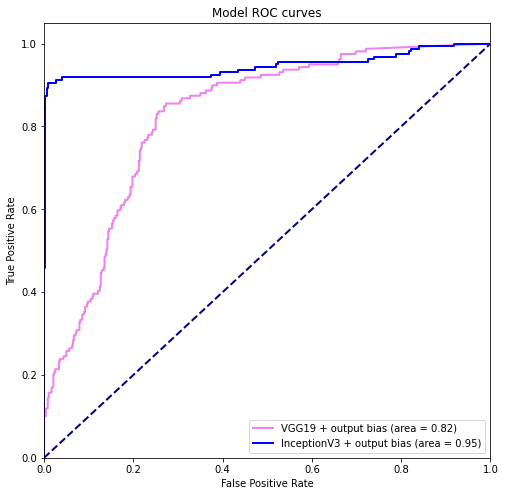

In [24]:
from sklearn.metrics import auc, roc_curve, f1_score
from sklearn.metrics import recall_score, precision_score, accuracy_score
models = [VGG_l3_model, IV3_model]#IV3frz_RMS_1,  IV3_SGD_1,IV3_RMS_2, VGG_RMS_1, VGG_SGD_1, VGG_RMS_2,VGG_SGD_2]
names = ['VGG19 + output bias', 'InceptionV3 + output bias']#['Freezed InceptionV3','InceptionV3','InceptionV3 + output bias',
        # 'VGG19 (oversampled data)', 'VGG19 + SGD', 
        # 'VGG19 + output bias', 'VGG19 + SGD + output bias']
colors = ['violet','blue','green','brown','darkorange', 'red','darkgreen']

plt.figure(figsize = (8,8))

for i in range(len(models)):
  m = models[i]
  y_score = None
  y_score = m.predict(X_test)
  fpr, tpr, thresholds = roc_curve(y_test, y_score)
  roc_auc = auc(fpr, tpr)
  plt.plot(fpr, tpr, color=colors[i],
         lw=2, label= names[i]+ ' (area = %0.2f)' % roc_auc)
  
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Model ROC curves')
plt.legend(loc="lower right")
plt.show()

### Single-Scale models of level3

Read tif from /content/drive/MyDrive/slides/tumor_110.tif with width: 94208, height: 71680
Slide includes 9 levels
--------------------------------------------------
Out of 1949 tissue patches, 1091 patches are predicted to have cancer
--------------------------------------------------
Classification report:
Accuracy: 0.9425
Precision: 0.9927
Recall: 0.9124
F1-score: 0.9508


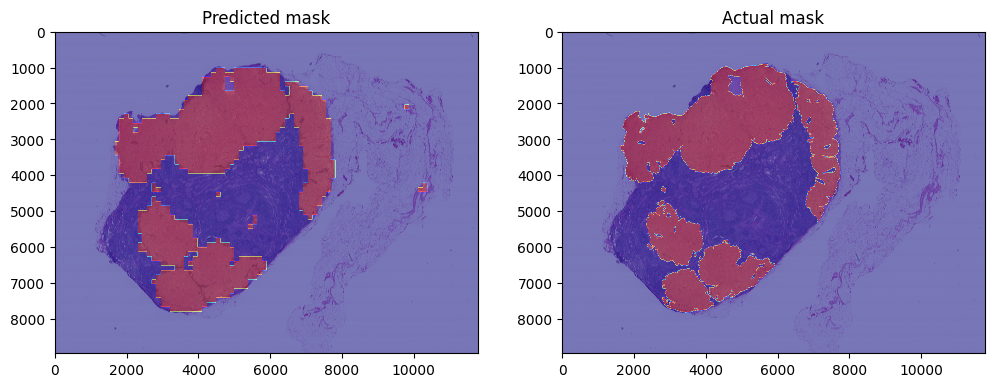

In [33]:
pred_mask, full_mask_image, full_slide_image, y_true, y_pred = full_pred(VGG_l3_model, idx='110', 
                                l4_model=None, level = 3, cancer_thres = 0.9)
metric_scores(y_true, y_pred)
plot_pred(pred_mask, full_mask_image, full_slide_image)

Read tif from /content/drive/MyDrive/slides/tumor_110.tif with width: 94208, height: 71680
Slide includes 9 levels
--------------------------------------------------
Out of 1949 tissue patches, 1065 patches are predicted to have cancer
--------------------------------------------------
Classification report:
Accuracy: 0.9312
Precision: 0.9944
Recall: 0.8922
F1-score: 0.9405


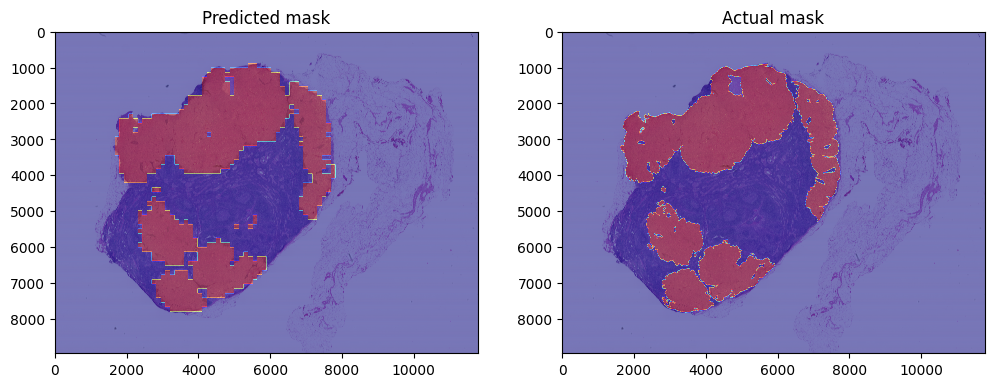

In [30]:

pred_mask, full_mask_image, full_slide_image, y_true, y_pred = full_pred(IV3_model, idx='110', 
                                l4_model=None, level = 3, cancer_thres = 0.8)
metric_scores(y_true, y_pred)
plot_pred(pred_mask, full_mask_image, full_slide_image)

Read tif from /content/drive/MyDrive/slides/tumor_101.tif with width: 139264, height: 71680
Slide includes 10 levels
--------------------------------------------------
Out of 1958 tissue patches, 152 patches are predicted to have cancer
--------------------------------------------------
Classification report:
Accuracy: 0.9244
Precision: 0.9145
Recall: 0.5073
F1-score: 0.6526


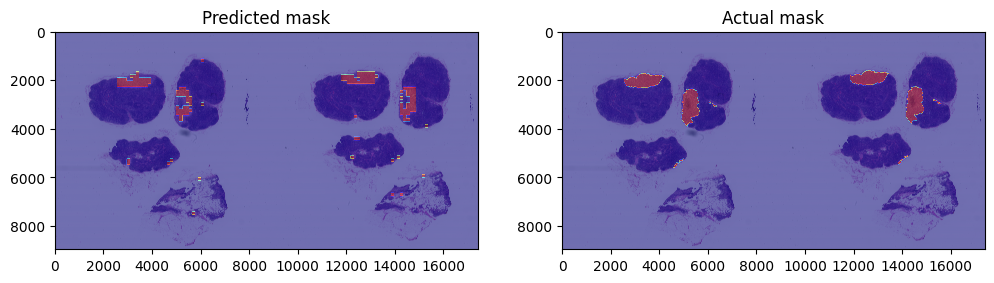

In [34]:
pred_mask, full_mask_image, full_slide_image, y_true, y_pred = full_pred(VGG_l3_model, idx='101', 
                                l4_model=None, level = 3, cancer_thres = 0.9)
metric_scores(y_true, y_pred)
plot_pred(pred_mask, full_mask_image, full_slide_image)

Read tif from /content/drive/MyDrive/slides/tumor_101.tif with width: 139264, height: 71680
Slide includes 10 levels
--------------------------------------------------
Out of 1958 tissue patches, 220 patches are predicted to have cancer
--------------------------------------------------
Classification report:
Accuracy: 0.9663
Precision: 0.9727
Recall: 0.781
F1-score: 0.8664


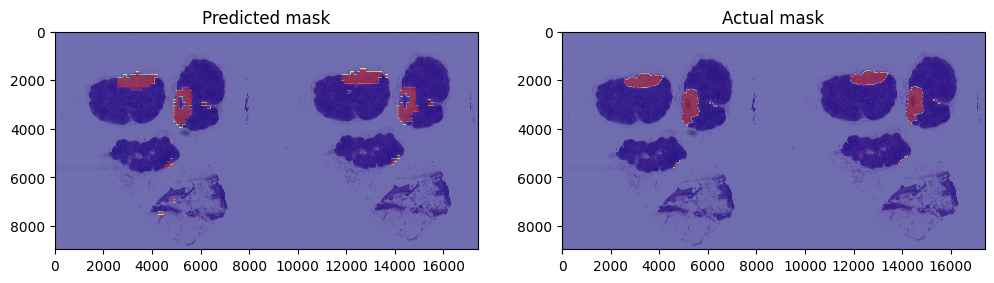

In [ ]:
#IMG_SIZE = 50
pred_mask, full_mask_image, full_slide_image, y_true, y_pred = full_pred(IV3_model, idx='101', 
                                l4_model=None, level = 3, cancer_thres = 0.8)
metric_scores(y_true, y_pred)
plot_pred(pred_mask, full_mask_image, full_slide_image)

Read tif from /content/drive/MyDrive/slides/tumor_096.tif with width: 131072, height: 71680
Slide includes 9 levels
--------------------------------------------------
Out of 1368 tissue patches, 50 patches are predicted to have cancer
--------------------------------------------------
Classification report:
Accuracy: 0.9539
Precision: 0.52
Recall: 0.4
F1-score: 0.4522


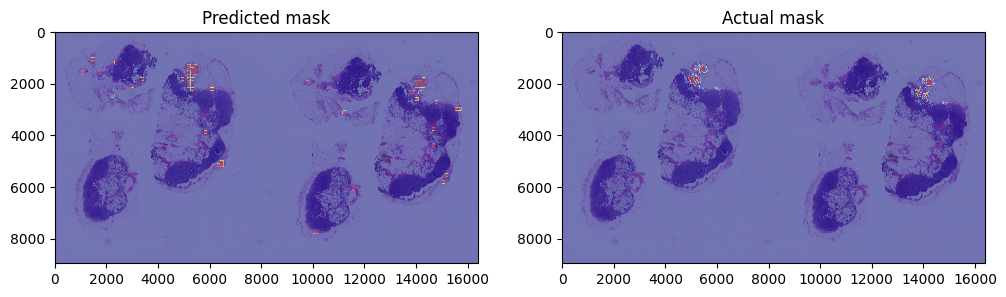

In [35]:
pred_mask, full_mask_image, full_slide_image, y_true, y_pred = full_pred(VGG_l3_model, idx='096', 
                                l4_model=None, level = 3, cancer_thres = 0.9)
metric_scores(y_true, y_pred)
plot_pred(pred_mask, full_mask_image, full_slide_image)

Read tif from /content/drive/MyDrive/slides/tumor_096.tif with width: 131072, height: 71680
Slide includes 9 levels
--------------------------------------------------
Out of 1368 tissue patches, 7 patches are predicted to have cancer
--------------------------------------------------
Classification report:
Accuracy: 0.9576
Precision: 1.0
Recall: 0.1077
F1-score: 0.1944


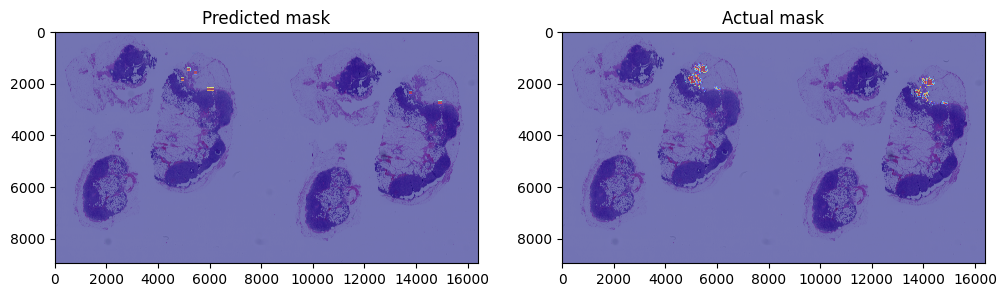

In [37]:
pred_mask, full_mask_image, full_slide_image, y_true, y_pred = full_pred(IV3_model, idx='096', 
                                l4_model=None, level = 3, cancer_thres = 0.8)
metric_scores(y_true, y_pred)
plot_pred(pred_mask, full_mask_image, full_slide_image)

### Multi-Scale model of level 3, 4

Read tif from /content/drive/MyDrive/slides/tumor_110.tif with width: 94208, height: 71680
Slide includes 9 levels
--------------------------------------------------
Out of 1949 tissue patches, 1029 patches are predicted to have cancer
--------------------------------------------------
Classification report:
Accuracy: 0.9159
Precision: 0.9971
Recall: 0.8644
F1-score: 0.926


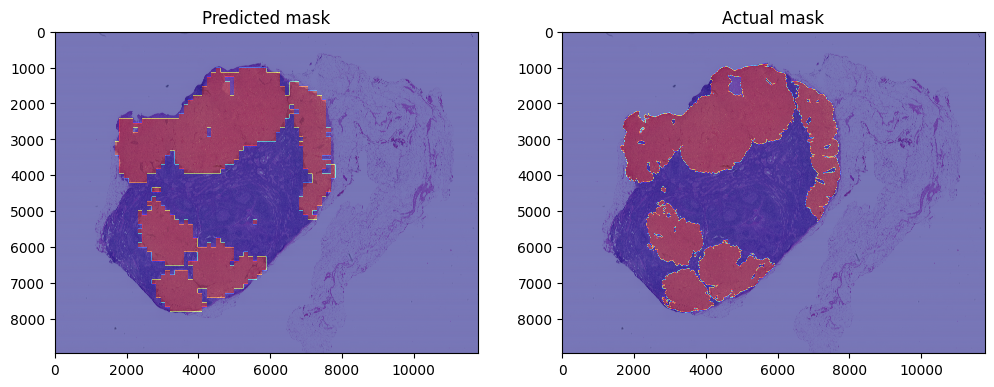

In [38]:
pred_mask, full_mask_image, full_slide_image, y_true, y_pred = full_pred(IV3_model, idx='110', 
                                l4_model=l4_model, level = 3, cancer_thres = 0.9)
metric_scores(y_true, y_pred)
plot_pred(pred_mask, full_mask_image, full_slide_image)

## References



1.   Detecting Cancer Metastases on Gigapixel Pathology Images (2017). Yun Liu, et al. https://arxiv.org/abs/1703.02442
2.   Tensorflow - Transfer learning and fine tuning. https://www.tensorflow.org/guide/keras/transfer_learning
3.   Tensorflow - Classification on imbalanced data. https://www.tensorflow.org/tutorials/structured_data/imbalanced_data
4.   tf.keras.applications. https://www.tensorflow.org/api_docs/python/tf/keras/applications?hl=en

Retrieved on April 29, 2021